# Graph Analysis

In [1]:
import pandas as pd
import numpy as np
from src.basic_project import preprocessing, extract_data, BasicModel
from gensim.matutils import corpus2dense, corpus2csc
from gensim.corpora import Dictionary
#from gensim.models.wrappers import LdaMallet
#------------------------------------------
#   Librerías para Semantic graphs
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as scsp
import seaborn as sns
from collections import Counter
from gensim.models.ldamodel import LdaModel
import random


### Create LDA embedding

In [2]:
texts, labels, costs, contributions = extract_data('data/projects.xlsx', 'data/SciVocCodes.xlsx')
texts = preprocessing(texts)

In [3]:
# Create a corpus
D = Dictionary([sentence.split(' ') for sentence in texts])
n_tokens = len(D)
reviews_bow = [D.doc2bow(doc.split(' ')) for doc in texts]

In [4]:
# compute using a LDA algorithm for topic modelling with 200 topics.
num_topics = 60
ldag = LdaModel(corpus=reviews_bow, id2word=D, num_topics=num_topics)

In [5]:
corpus_size = len(reviews_bow)
print(f"Dataset contains {corpus_size} documents")

Dataset contains 32052 documents


Como tiene muchos documentos lo que haremos será simplicar la muestra a unos 1000 documentos

In [6]:
corpus = random.sample(reviews_bow, 1000)
print(f"Dataset contains {len(corpus)} documents")

Dataset contains 1000 documents


In [7]:
# create sparse corpus
corpus_ldag = ldag[corpus] 
num_docs = 10000
X = corpus2csc(corpus_ldag, num_terms=n_tokens, num_docs=num_docs).T


In [12]:
n_topics = X.shape[1]
print(f"Number of topics: {n_topics}")
print(f"X: sparse matrix with {X.nnz} nonzero values out of {num_docs * n_topics}")

Number of topics: 122697
X: sparse matrix with 8854 nonzero values out of 1226970000


In [13]:
# Note that the embedding is shown in sparse format, showing the non-zero values only. The proportion of zero entries is
print(f"{(1 - X.nnz / num_docs / n_topics) * 100:.2f} % ")

100.00 % 


In [14]:
# All other entries are values in  [0,1] . 
# Since the embedding space is probabilistic the row vectors should sum up to one. 
# However, we can check that this is no exactly the case: 
print(f"Average row sum: {np.mean(X.sum(axis=1).T):.2f}")

Average row sum: 0.98


In [16]:
# Normalization:
X = scsp.csr_matrix(X / np.sum(X, axis=1))
print(f"Average row sum: {np.mean(X.sum(axis=1).T)}")

Average row sum: 1.0


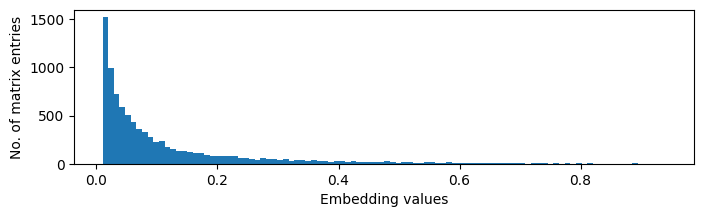

In [17]:
plt.figure(figsize=(8, 2))
plt.hist(X.data, bins=100)
plt.xlabel('Embedding values')
plt.ylabel('No. of matrix entries')
plt.show()

Semantic Similarity Measures

In [18]:
i = 0
xi = X[i, :]
BC = np.multiply(np.sqrt(xi),np.sqrt(X[1:].T)) # Excluimos el elemento 0
print('BC: ',BC)

BC:    (0, 972)	0.035358285667733254
  (0, 958)	0.03097050048164875
  (0, 955)	0.01926426686436163
  (0, 949)	0.025979041332932672
  (0, 941)	0.04089616069349749
  (0, 893)	0.021066718653952776
  (0, 890)	0.03126592521408187
  (0, 877)	0.03338683632065053
  (0, 868)	0.013768459435943785
  (0, 823)	0.013306521148124957
  (0, 814)	0.07609418602795714
  (0, 809)	0.015852624665706985
  (0, 802)	0.06054038805301296
  (0, 793)	0.044091212465069404
  (0, 740)	0.029026180865629376
  (0, 733)	0.02852029781411354
  (0, 731)	0.03713655119984523
  (0, 708)	0.014934775175806726
  (0, 706)	0.05538018241980341
  (0, 673)	0.013085923536479664
  (0, 665)	0.06101871453515984
  (0, 645)	0.017288675503282273
  (0, 644)	0.03887997831206278
  (0, 606)	0.02374508773376537
  (0, 596)	0.022364744381439882
  :	:
  (0, 99)	0.07140441339474786
  (0, 97)	0.4068854359562708
  (0, 95)	0.10178336108089683
  (0, 84)	0.46151349375878786
  (0, 81)	0.3275535938133529
  (0, 80)	0.24927238650294498
  (0, 78)	0.226979978905

* Compute the indices of the least similar and the most similar documents in the dataframe (excluding the document itself). Maybe you can use numpy methods argmin and argmax.

In [19]:
arg_max = np.argmax(BC)
print('Most similar: ',arg_max)
arg_min = np.argmin(BC)
print('Least similar: ',arg_min)

Most similar:  272
Least similar:  2


Compute the similarity matrix S based on the BC and print:
* The number of nonzero components in S (hint: you can use method nnz from numpy)
* The proportion of nonzero components in S

In [20]:
S = np.multiply(np.sqrt(X),np.sqrt(X.T))

print('Number of nonzero:',S.nnz)
print(f"NON-ZERO proportion = {(S.nnz/(S.shape[0]*S.shape[1]))*100:0.2f} %")

Number of nonzero: 809248
NON-ZERO proportion = 80.92 %


In [21]:
# Matrix is symmetric. Keep only upper triangular part
from scipy.sparse import triu
S = triu(S,k = 1) # above diagonal
print('Number of non-zero components in S:', S.nnz )

Number of non-zero components in S: 404124


Semantic graph

In [22]:
n_nodes = num_docs
n_edges = S.nnz
n_edges_per_node = np.round(n_edges/n_nodes)

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of edges per node: {n_edges_per_node}")
      

Number of nodes: 10000
Number of edges: 404124
Number of edges per node: 40.0


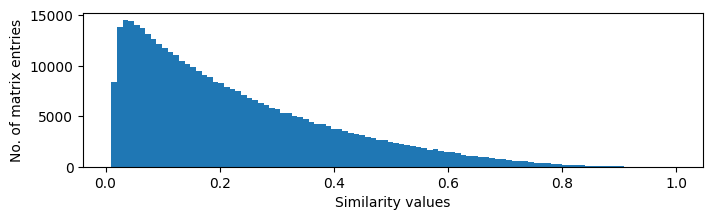

In [23]:
plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.xlabel('Similarity values')
plt.ylabel('No. of matrix entries')
plt.show()

* Apply a threshold to  𝐒  in order to get a subgraph with an average of 10 edges per node.

* The similarity values whose value was less than plus or minus 0.66 are eliminated.

In [24]:
# Set average number of edges per node
n_edges_per_node = 10
sample_factor = num_docs / corpus_size

# Compute threshold to get the target number of edges

n_edges = n_nodes * n_edges_per_node
sort = np.sort(S.data)
inv_sort = sort[::-1]
thr = inv_sort[n_edges]

# Apply the threshold to similarity matrix
S.data[S.data<thr] = 0
S.eliminate_zeros()

n_links = len(S.data)/2/sample_factor**2

print(f"Threshold: {thr:.4f}")
print(f"Number of edges: {n_edges}")
print(f"Estimated number of links in full corpus: {n_links:.2f}")

Threshold: 0.3277
Number of edges: 100000
Estimated number of links in full corpus: 513670.49


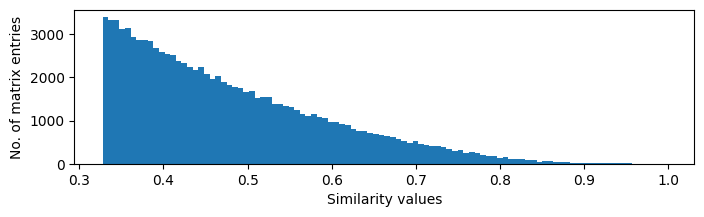

In [25]:
plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.xlabel('Similarity values')
plt.ylabel('No. of matrix entries')
plt.show()

##### Semantic Graph


In [26]:
G = nx.from_scipy_sparse_matrix(S)

/var/folders/z8/52zfs8h97qj1h6xxcnn1r3mh0000gn/T/ipykernel_39796/499930988.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(S)


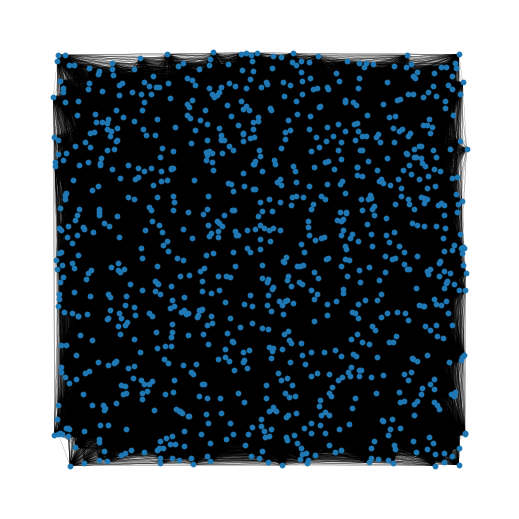

In [29]:
# ########################
# Testing a random  layout

positions = nx.drawing.layout.random_layout(G)
plt.figure(figsize=(5,5))
nx.draw(G, positions, node_size=10, width=0.10)

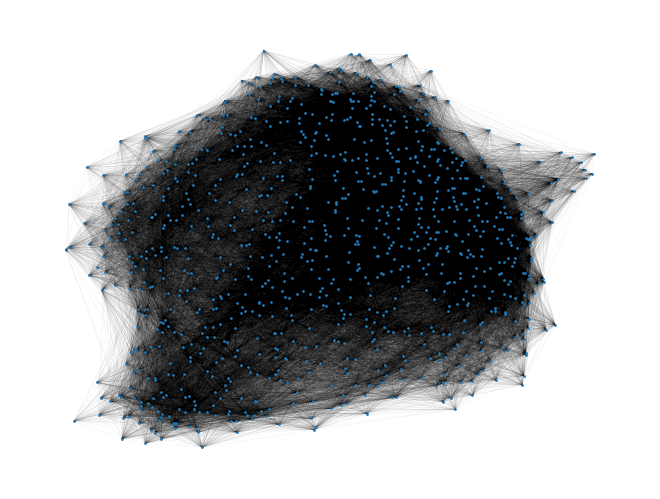

In [30]:
# Compute positions
positions = nx.spring_layout(G, iterations = 50, seed = 0)

# Draw graph
nx.draw(G, positions, node_size=1, width=0.02)

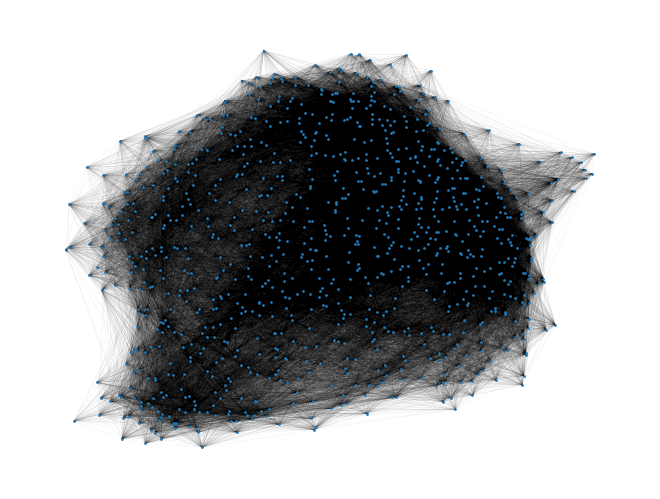

In [31]:
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc)
nx.draw(G_lcc, positions, node_size=1, width=0.02)